# Use jobs for a smoothless experience with pulse sequence sweeps.
One of the main reason to use pulse-level control is to characterize a quantum system at the lowest level. Extracting this experimental information will allow for building a device Hamiltonian model that could then be compared with results obtained from the real device.

Often, protocols to obtain these experimental data consist in varying a control parameter and record the response of the system. You can find examples in the notebook [here](./1_Bringup_experiments.ipynb). Here we will revisit this notebook by taking advantage of Hybrid Jobs. We will encapsulate a frequency sweep in a single job instance, which will give tasks created from within the job priority access to the device.priority and group all the task results together.

You can learn more about Hybrid Jobs [here](../hybrid_jobs/0_Creating_your_first_Hybrid_Job/Creating_your_first_Hybrid_Job.ipynb) and how to use them to implement hybrid classical-quantum algorithms in a production environment. 

You can use either Rigetti's Aspen M-3 or OQC's Lucy device to run this notebook.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

Let's first import some packages to construct pulse sequences and analyze results.

In [11]:
%matplotlib inline

from braket.aws import AwsQuantumJob

## Imports for function fitting
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

## Qubit spectropscopy

Qubit spectroscopy is one of the first step to charaterize a qubit. While this information is already present in the frame properties, we will build a pulse sequence to estimate the transition frequency between the ground state and the first excited state.

Our code will reuse large parts of the notebook [here](1_Bringup_experiments.ipynb).

The main code of the algorithm is located in a [python file](./qubit_spectroscopy/qubit_spectroscopy_sweep.py) and consists in generating a single-pulse `PulseSequence` with a varying frequency. The script is parametrized by the following parameters:
- `N_shots` to specify the number of repetitions
- `N_steps` to refine the resolution of the frequency sweep
- `qubit` to choose the qubit to probe
- `frequency_start` to set the lowest frequency of the sweep
- `frequency_stop` to set the highest frequency of the sweep

These parameters can be set with user-defined values passed through the `hyperparameters` argument.

In [3]:
hyperparameters = {"N_shots": 100, "N_steps": 25, "qubit": 4}

A job is launched via the `create` method:

In [4]:
job = AwsQuantumJob.create(
    device="arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3",
    source_module="qubit_spectroscopy/qubit_spectroscopy_sweep.py",
    hyperparameters=hyperparameters,
    wait_until_complete=True,
)

Initializing Braket Job: arn:aws:braket:us-west-1:824069584567:job/braket-job-default-1689091850121
........................
2023-07-11 16:12:55,299 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-11 16:12:55,313 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-11 16:12:55,325 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-11 16:12:55,335 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {},
    "current_host": "algo-1",
    "framework_module": null,
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "N_shots": 100,
        "N_steps": 25,
        "qubit": 4
    },
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {},
    "input_dir": "/opt/ml/input",
    "is_master": true,
    "job_name": "2555d7d8-fd3c-463b-a56b-c5a03b7f1f6a

You can now retrieve the collection of tasks associated with your Qubit spectroscopy sweep. If you don't have access to the job object created with `AwsQuantumJob.create`, you could always recreate it from the job arn `job_arn` that you can obtain from the [Braket console](https://console.aws.amazon.com/braket/) (use the region corresponding to the device that you used):

In [5]:
# job = AwsQuantumJob(job_arn)

After executing the job, we are ready to analyze the results. We will use a simple Gaussian fit function to extract the transition frequency.

In [6]:
def resonance_fit(x, A, A0, w, x0):
    return A0-A*np.exp(-(x-x0)**2/w**2)

The result format is the same as with circuits, which means that `result()` will return a task result object that includes a counter with the number of occurences for each eigenstate of the measurement basis. Since we have been using a batch, we can quickly construct the probability to measure the state $|0\rangle$. 

The data are then plotted and fitted with the previously defined fit function.

In [7]:
results = job.result()  # will return once job.state() = "COMPLETED", should be 4 minutes
print("populations in |0>: ", results["populations in |0>"])
print("frequencies: ", results["frequencies"])

populations in |0>:  [0.97, 0.98, 0.95, 0.98, 0.97, 0.99, 0.97, 0.98, 1.0, 0.86, 0.53, 0.41, 0.2, 0.34, 0.54, 0.77, 0.91, 0.98, 0.97, 0.99, 0.97, 0.99, 0.99, 0.98, 1.0]
frequencies:  [5161931123.13734, 5165056123.13734, 5168181123.13734, 5171306123.13734, 5174431123.13734, 5177556123.13734, 5180681123.13734, 5183806123.13734, 5186931123.13734, 5190056123.13734, 5193181123.13734, 5196306123.13734, 5199431123.13734, 5202556123.13734, 5205681123.13734, 5208806123.13734, 5211931123.13734, 5215056123.13734, 5218181123.13734, 5221306123.13734, 5224431123.13734, 5227556123.13734, 5230681123.13734, 5233806123.13734, 5236931123.13734]


Measured resonance frequency: 5199.8 GHz


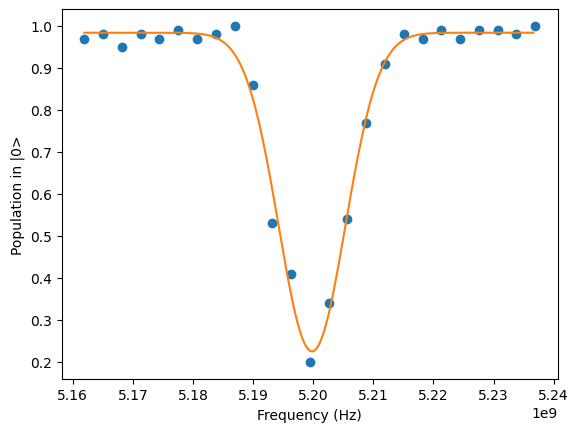

In [10]:
x, y = results["frequencies"], results["populations in |0>"]

initial_guess=[1/2, 1, 10e6, (x[-1]+x[0])/2] # Amplitude, Offset, width, centerFrequency
optimal_params, _ = scipy.optimize.curve_fit(resonance_fit, x, y, p0=initial_guess)
x_fit = np.arange(x[0],x[-1], np.diff(x)[0]/10)
y_fit = resonance_fit(x_fit, *optimal_params)

plt.figure()
plt.plot(x,y, 'o')
plt.plot(x_fit,y_fit)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Population in |0>")

resonance_frequency = optimal_params[3]
print('Measured resonance frequency:', round(resonance_frequency*1e-6,2), 'GHz')

You have seen how to use jobs to run a qubit spectroscopy measurement on a single qubit. This is one of the first step to characterize a qubit systems. As one example to go further with jobs, one can now think about automatizing a more complex procedure with subsequent experiments and feedback loops for accurate calibrations.

In [9]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 2500, 'tasks': {'COMPLETED': 25}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 8.375 USD
